# Set up

## Package Loading

In [ ]:
import pandas as pd
import numpy as np
import itertools
!pip install emoji
import emoji
import re
!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from sklearn.utils.multiclass import unique_labels
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, make_scorer
import matplotlib.pyplot as plt
import time
import joblib

from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Set Up paths

In [ ]:
# Parent paths
google_path = '/content/drive/My Drive/'
local_path = '/home/v.zevallosm/'
parent_path = google_path

#Specific paths
path_train = parent_path+"team project/data set/dataset search/twitter_and_cyberbullying/data.csv" 
path_test = parent_path+"team project/data set/dataset search/Twitter Sentiment Analysis/test_tweet.csv" 
path_proprocessed = parent_path+"team project/codes/models/with_stemming_nltk_cyber&twitter/text_without_sw.csv"


path_hyperparameters_sgd = parent_path+"team project/codes/models/best parameters/sgd.csv"
path_hyperparameters_svm = parent_path+"team project/codes/models/best parameters/svm.csv"
path_hyperparameters_et = parent_path+"team project/codes/models/best parameters/et.csv"
path_hyperparameters_rf = parent_path+"team project/codes/models/best parameters/rf.csv"
path_hyperparameters_nb = parent_path+"team project/codes/models/with_stemming_nltk_cyber&twitter/nb.csv"
path_hyperparameters_knn = parent_path+"team project/codes/models/best parameters/knn.csv"
path_hyperparameters_lr = parent_path+"team project/codes/models/best parameters/lr.csv"
path_hyperparameters_dt = parent_path+"team project/codes/models/best parameters/dt.csv"

path_best_parameters_sgd = parent_path+"team project/codes/models/sgd.pkl"
path_best_parameters_svm = parent_path+"team project/codes/models/svm.pkl"
path_best_parameters_et = parent_path+"team project/codes/models/et.pkl"
path_best_parameters_rf = parent_path+"team project/codes/models/rf.pkl"
path_best_parameters_nb = parent_path+"team project/codes/models/with_stemming_nltk_cyber&twitter/nb.pkl"
path_best_parameters_knn = parent_path+"team project/codes/models/knn.pkl"
path_best_parameters_lr = parent_path+"team project/codes/models/lr.pkl"
path_best_parameters_dt = parent_path+"team project/codes/models/dt.pkl"

## Set Up Functions

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Data Exploration

In [ ]:
train = pd.read_csv(path_train)
test = pd.read_csv(path_test)

In [ ]:
print(train.shape)
print(test.shape)
print()
print(train.label.unique())
print(train.isnull().any())
print(test.isnull().any())
train.head()

(79654, 2)
(17197, 2)

[0 1]
tweet    False
label    False
dtype: bool
id       False
tweet    False
dtype: bool


,tweet,label
0,"In other words #katandandre, your food was cra...",0
1,Why is #aussietv so white? #MKR #theblock #ImA...,0
2,@XochitlSuckkks a classy whore? Or more red ve...,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0
4,@RudhoeEnglish This is an ISIS account pretend...,0


# Data Preprocessing

## Data Cleansing

In [ ]:
content = train['tweet']
label = train['label']

In [ ]:
def dataCleansing(data):

    # Convert text to lowercase
    data = data.lower()
    
    #Removing URLs
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    #Remove non-english words
    data =  re.sub("[^a-z]+", " ",data)
        
    return data

preprocessed_text = []
for i in range(len(content)):
    preprocessed_text.append(dataCleansing(content[i]))
preprocessed_text[:5]

['in other words katandandre your food was crapilicious mkr',
 'why is aussietv so white mkr theblock imacelebrityau today sunrise studio neighbours wonderlandten etc',
 ' xochitlsuckkks a classy whore or more red velvet cupcakes ',
 ' jason gio meh p thanks for the heads up but not too concerned about another angry dude on twitter ',
 ' rudhoeenglish this is an isis account pretending to be a kurdish account like islam it is all lies ']

## Tokenization 

In [ ]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()
stop_words = set(stopwords.words('english')) 

list_tokens = []
# for every tweet tokenize
for text in preprocessed_text:
  list_stem = []
  word_tokens = word_tokenize(text)
  for word in word_tokens:
    word_tokens = ps.stem(word)
    list_stem.append(word_tokens)
  list_tokens.append(list_stem)

list_all_filtered = []
for tokens in list_tokens: 
  list_filtered = [] 
  for word in tokens: 
      if word not in stop_words: 
          list_filtered.append(word) 
  list_all_filtered.append(list_filtered)


In [ ]:
# preprocessed text without stopwords saved in csv
list_text_without_sw = []
for tokens in list_all_filtered:
  sentence = ' '.join(tokens)
  list_text_without_sw.append(sentence)
print(list_text_without_sw[1])


text_without_sw = pd.DataFrame(list_text_without_sw,columns=['text'])
text_without_sw = pd.concat([label,text_without_sw], axis=1)
text_without_sw.to_csv('text_without_sw.csv',index=False)
text_without_sw.head()

whi aussietv white mkr theblock imacelebrityau today sunris studio neighbour wonderlandten etc


,label,text
0,0,word katandandr food wa crapilici mkr
1,0,whi aussietv white mkr theblock imacelebrityau...
2,0,xochitlsuckkk classi whore red velvet cupcak
3,0,jason gio meh p thank head concern anoth angri...
4,0,rudhoeenglish thi isi account pretend kurdish ...


# Balance Dataset

In [ ]:
# loading preprocessd data
df = pd.read_csv(path_proprocessed)
df = df[df['text'].apply(lambda x: isinstance(x, str))] # Temporal solution

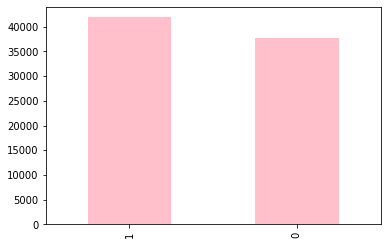

In [ ]:
df['label'].value_counts().plot.bar(color = 'pink', figsize = (6, 4))

## Train, Validation, Test Split

In [ ]:
# split
x_train, x_test = train_test_split(df, test_size=0.2, random_state = 453, stratify=df['label'])
x_test, x_valid = train_test_split(x_test, test_size=0.5 , random_state = 453, stratify= x_test['label'])

y_train = x_train['label']
x_train = x_train['text']
#del x_train['label']

y_test = x_test['label']
x_test = x_test['text']
#del x_test['label']

y_valid = x_valid['label']
x_valid = x_valid['text']
#del x_valid['label']

print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)
display(x_train)

(63604,)
(7951,)
(7951,)


44974    pull pistol make nigga look dam sick like seen...
40868    done enough bullshit one tell shit see dumb as...
50485    user disgust infuri inhuman thi guy ha got sto...
20195    haha oh come think god know substitut chit shi...
29550    symbo ic bsd move away includ gpled packag bas...
                               ...                        
13699    would assum white gay problemat hurt shock mak...
23715    oh doe thi mean soro gate clinton realli musli...
65603                                      danc shi wordan
21602    hey rudi whi tell us offici narr fairi tale st...
44125    terminolog doe lot chang thing rememb white pe...
Name: text, Length: 63604, dtype: object

# Training Models in a Pipeline

## Pipeline Set Up

In [ ]:
# define transforms
vectorizer = TfidfVectorizer()
sampling = RandomUnderSampler(random_state=453)

# define the scoring function
f1 = make_scorer(f1_score)

# set up cross validation configuration
cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)


## Naïve Bayes

In [ ]:
# Optimize parameters for NB Classifier
from sklearn.naive_bayes import MultinomialNB
estimator = MultinomialNB()

# Define grid of posible hyperparamters values 
parameters = {
    'vectorizer__max_df': [0.25, 0.5, 0.75, 1.0],
    'vectorizer__smooth_idf': (True, False),
    'vectorizer__norm': ('l1', 'l2', None),
    'estimator__alpha': [ 0.0001, 0.001, 0.01, 0.1, 1, 10],
}

# Create a pipeline
pipeline = Pipeline([ ('vectorizer', vectorizer), ('balancing', sampling), ('estimator', estimator) ])
print(pipeline)

# Hyperparameter optimization with Grid Search
start_time = time.time()
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=cv, return_train_score=False, n_jobs=-1, verbose=2)
grid_search_estimator.fit(x_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print("Multinomial NBClassifier: {}% F1-score for class 'hate-speech' with parameters {}".format(grid_search_estimator.best_score_ * 100, grid_search_estimator.best_params_))

# Save hyperparameter optmization results
df_hyper = pd.DataFrame(grid_search_estimator.cv_results_)
df_hyper.to_csv(path_hyperparameters_nb, index=False)

# Save best hyperparameters values
joblib.dump(grid_search_estimator.best_params_, path_best_parameters_nb, compress = 1) # Only best parameters


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('balancing', RandomUnderSampler(random_state=453)),
                ('estimator', MultinomialNB())])
Fitting 8 folds for each of 144 candidates, totalling 1152 fits
--- 782.4867734909058 seconds ---
Multinomial NBClassifier: 87.79496468682882% F1-score for class 'hate-speech' with parameters {'estimator__alpha': 1, 'vectorizer__max_df': 0.25, 'vectorizer__norm': 'l1', 'vectorizer__smooth_idf': False}


['/content/drive/My Drive/team project/codes/models/with_stemming_nltk_cyber&twitter/nb.pkl']

              precision    recall  f1-score   support

           0       0.92      0.79      0.85      3763
           1       0.83      0.94      0.88      4188

    accuracy                           0.87      7951
   macro avg       0.88      0.86      0.87      7951
weighted avg       0.87      0.87      0.87      7951



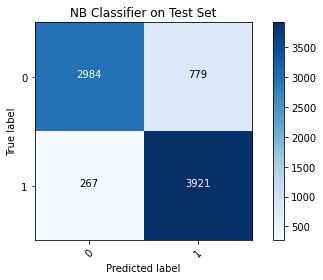

In [ ]:
prediction = grid_search_estimator.predict(x_test)
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(y_test), title = "NB Classifier on Test Set")
print(classification_report(y_test, prediction))